<a href="https://colab.research.google.com/github/nicolasquant/Cases/blob/main/Case_Kinea/Case_Kinea_Nicolas_Cenedesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parte I - Fluxo NTN-B (Com Juros Semestral) + Duration De Macaulay

###Introdução

Na realizacao da compra de um titulo publico do tipo NTN-B com juros semestrais, há um fluxo de caixa definido por pagamentos semestrais (cupons), PU (valor a ser pago pelo titulo) e o principal (valor esse a ser recebido no ultimo periodo de recebimento do titulo, junto ao último cupom).

No código a seguir, iremos realizar a precificação do título público (obtenção do PU) a partir de algumas variáveis definidas (inputs), como: a taxa real, taxa de cupom, inflação, Valor Nominal Ajustado (VNA) e prazo de vencimento do título.

Vale ressaltar que o código a seguir possibilita a adição dessas variáveis de forma manual, adequando-o a qualquer aplicaçaõ voltada à precificação de títulos semelhantes ao NTN-B.

Por fim, realizaremos o cálculo da Duration de Macaulay


###Definindo as Variáveis fundamentais

Possuímos 5 inputs obrigatórios para realizar o cálculo do PU de um NTN-B, dentre eles:

$VNA_db$ = Valor Nominal Atualizado na data-sabe (no caso do nosso codigo, nossa data base será referente ao mes 09/2025 onde possui o valor de emissao do titulo já atualizado pela inflacao , porém, a real data base, ou seja, a data de criação do título foi em 15 de Julho de 2000)

$IPCA$ = inflação projetada

$T$ = prazo de vencimento do título

$c$ = taxa de cupom do título (no caso do NTN-B, essa taxa é de 6% a.a)

$r$ = taxa real (define o retorno exigido pelo comprador do título e pode variar diariamente dependendo da cotacao do mercado)


In [1]:
# ----------------------------------------------------
#               INPUTS VARIÁVEIS PRIMARIAS
# ----------------------------------------------------

# INPUT 1: Taxa Real de Juros Desejada (a.a.)
taxa_real_anual = 0.0764  # 7,64% ao ano ( note que ao aumental a taxa, diminuimos o PU final, sera que isso ta certo?) --- sim, esta correto, isso acontece por conta da diminuicao do valor presente consequente da elevacao da taxa real.

# INPUT 2: Prazo de Vencimento (em anos)
prazo_vencimento_em_anos = 10  # 10 anos (20 semestres)

# INPUT 3: IPCA
IPCA_proj_anual = 0.0465 # 4,65% ao ano --- note que a alteracao da inflacao nao altera o PU final (sera que isso ta certo)

# INPUT 4: Taxa de Cupom (Definida pelo título)
taxa_cupom_anual = 0.06 # 6% a.a.

### Definicões das variáveis secundárias

As variáveis secundárias seriam aquelas dependentes das variáveis primárias antes definidas.
Em um cenario geral, as taxas convencionais sao definidas anualmente, porém, para um fluxo de caixa semestral, como o que ocorre na compra de um NTN-B com juros semestral, devemos realizar a conversao das três taxas: IPCA, taxa real, taxa de cupom para periodo semestral.
Além disso, devemos definir uma quarta variavel secundária, chamada de Taxa Nominal de Desconto Semestral (Fórmula de Fisher)

In [ ]:
# ----------------------------------------------------
#               CÁLCULO VARIÁVEIS SECUNDÁRIAS
# ----------------------------------------------------

# 1. Parâmetros do Tempo
periodos_semestres = prazo_vencimento_em_anos * 2

# 2. Taxas Semestrais
# Taxa Real Semestral
taxa_real_semestral = (1 + taxa_real_anual)**0.5 - 1
# Inflação Semestral
IPCA_semestral = (1 + IPCA_proj_anual)**0.5 - 1
# Taxa Nominal de Desconto Semestral (Fórmula de Fisher)
taxa_nominal_semestral = (1 + taxa_real_semestral) * (1 + IPCA_semestral) - 1

# Cupom Semestral (%)
cupom_semestral_pct = (1 + taxa_cupom_anual)**0.5 - 1

###Cálculo do Preço Unitário

O Preço Unitário (PU) é a soma dos valores presentes dos fluxos de caixa. A Duration de Macaulay é a média ponderada do tempo para receber esses fluxos, calculada em semestres e convertida para anos:

$$PU = \sum_{t=1}^{N} VP_t$$

Onde $VP_t = \frac{FC_{Nominal, t}}{(1 + i_{nom})^t}$.

$PU$	Preço Unitário Atual do título (nosso foco)

$VP_t$ = Valor Presente do fluxo de caixa no semestre t.

$VNA_t$ = Valor Nominal Atualizado no semestre t (reajustado pela inflação semestral).

$J_t$	Pagamento do Cupom Nominal no semestre t.

$P_t$ Pagamento do Principal Nominal (igual a VNAN, pago apenas no vencimento N).


$FC_Nominal$	Fluxo de Caixa Nominal Total no semestre t (Jt​+Pt​).




###Duration de Macaulay

$$D_{Mac} \text{ (semestres)} = \frac{\sum_{t=1}^{N} t \times VP_t}{PU}$$

$DMac$ Duration de Macaulay (em anos).

In [ ]:
import numpy as np

def calcular_pu_ntnb(taxa_real_anual, prazo_anos, inflacao_projetada_anual=0.04, vna_inicial=4535.996085 , cupom_anual=0.06):
    """
    Calcula o Preço Unitário (PU) de uma NTN-B (Tesouro IPCA com Juros Semestrais).

    Args:
        taxa_real_anual (float): Taxa real de juros desejada (a.a.), ex: 0.05 para 5%.
        prazo_anos (int): Prazo até o vencimento em anos.
        inflacao_projetada_anual (float): Inflação (IPCA) projetada (a.a.), ex: 0.04.
        vna_inicial (float): Valor Nominal Atualizado inicial de referência. Nesse caso, pegamos o VNA inicial de referencia
        cupom_anual (float): Taxa de cupom anual da NTN-B (padrão é 0.06).

    Returns:
        float: O Preço Unitário (PU) atual do título.
    """

    # Inicializa o PU e o VNA
    pu_atual = 0.0
    vna_atual = vna_inicial

    # --- Tabela de Fluxo de Pagamentos ---
    print("\n--- Fluxo de Pagamentos (Valores Nominais) ---")
    print(f"{'Período (Semestre)':<20} | {'VNA Atualizado (R$)':<20} | {'Cupom (R$)':<15} | {'Principal (R$)':<15} | {'FC Total (R$)':<15} | {'Valor Presente (R$)':<20}")
    print("-" * 130)

    # 3. Cálculo do Fluxo e do PU
    for t in range(1, periodos_semestres + 1):

        # 3.1. Atualização do VNA (pela inflação)
        # O VNA é atualizado a cada período pela inflação projetada
        vna_atual *= (1 + inflacao_semestral)

        # 3.2. Fluxo de Caixa do Período
        cupom_nominal = vna_atual * cupom_semestral_pct
        principal = 0.0

        # O pagamento do principal (VNA final) ocorre apenas no último período
        if t == periodos_semestres:
            principal = vna_atual

        fluxo_caixa_total = cupom_nominal + principal

        # 3.3. Desconto a Valor Presente
        # O fluxo nominal é descontado pela taxa nominal semestral
        fator_desconto = (1 + taxa_nominal_semestral)**t # usamos essa eq pra trazer os cupons a valor presente.
        valor_presente = fluxo_caixa_total / fator_desconto

        # 3.4. Acumula o PU
        pu_atual += valor_presente

        # Exibe a linha do fluxo (opcional, mas útil para conferência)
        print(f"{t:<20} | {vna_atual:<20.2f} | {cupom_nominal:<15.2f} | {principal:<15.2f} | {fluxo_caixa_total:<15.2f} | {valor_presente:<20.2f}")

    return pu_atual

# ----------------------------------------------------
#               EXECUÇÃO
# ----------------------------------------------------

pu_resultado = calcular_pu_ntnb(
    taxa_real_anual=taxa_desejada,
    prazo_anos=prazo_vencimento,
    inflacao_projetada_anual=inflacao_proj
)

# ----------------------------------------------------
#               OUTPUT FINAL
# ----------------------------------------------------

print("\n" + "=" * 50)
print(f"Taxa Real de Juros Anual (Input): {taxa_desejada*100:.2f}%")
print(f"Prazo de Vencimento (Input): {prazo_vencimento} anos")
print("-" * 50)
print(f"**Preço Unitário (PU) Atual do Título:** R$ {pu_resultado:.2f}")
print("=" * 50)


--- Fluxo de Pagamentos (Valores Nominais) ---
Período (Semestre)   | VNA Atualizado (R$)  | Cupom (R$)      | Principal (R$)  | FC Total (R$)   | Valor Presente (R$) 
----------------------------------------------------------------------------------------------------------------------------------
1                    | 4640.26              | 137.18          | 0.00            | 137.18          | 129.25              
2                    | 4746.92              | 140.33          | 0.00            | 140.33          | 124.58              
3                    | 4856.03              | 143.56          | 0.00            | 143.56          | 120.08              
4                    | 4967.65              | 146.86          | 0.00            | 146.86          | 115.74              
5                    | 5081.84              | 150.23          | 0.00            | 150.23          | 111.55              
6                    | 5198.65              | 153.69          | 0.00            | 153.69       

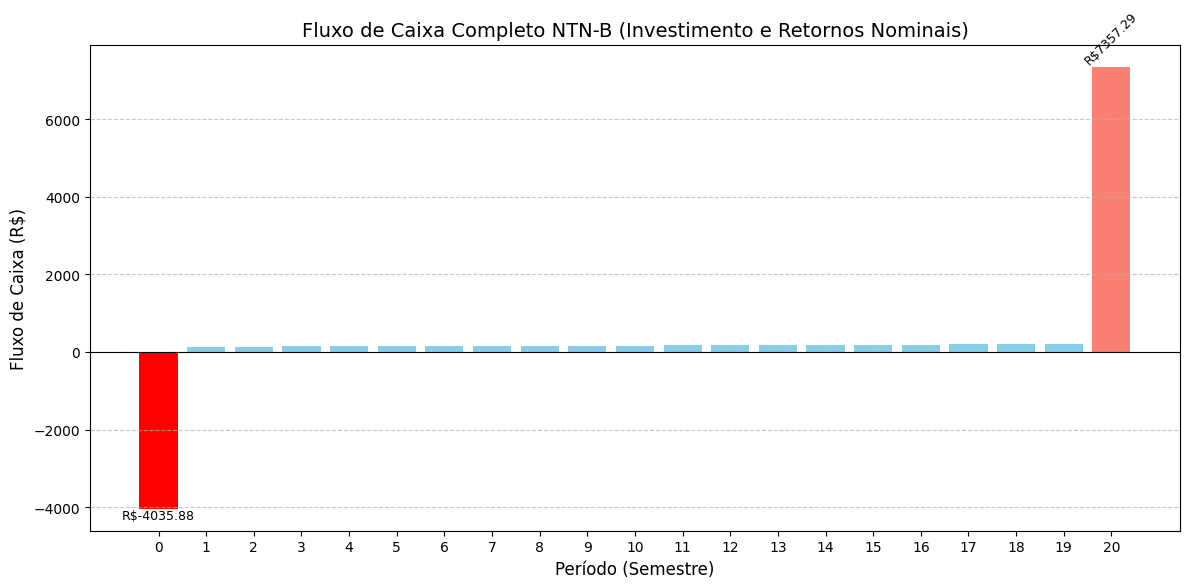


**Preço Unitário (PU) Calculado:** R$ 4035.88 (Corresponde à Saída em t=0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calcular_pu_ntnb_e_fluxo_completo(taxa_real_anual, prazo_anos, inflacao_projetada_anual=0.0465, vna_inicial=4535.996085, cupom_anual=0.06):
    """
    Calcula o PU e o Fluxo de Caixa Completo:
    FC[0] = -PU (Investimento Inicial)
    FC[1]...FC[N] = Cupons Nominais + Principal (Entradas)

    Retorna: (PU_atual, periodos_com_t0, fluxo_caixa_completo)
    """
    # 1. Parâmetros e Taxas
    periodos_semestres = int(prazo_anos * 2)
    taxa_real_semestral = (1 + taxa_real_anual)**0.5 - 1
    inflacao_semestral = (1 + inflacao_projetada_anual)**0.5 - 1
    taxa_nominal_semestral = (1 + taxa_real_semestral) * (1 + inflacao_semestral) - 1
    cupom_semestral_pct = (1 + cupom_anual)**0.5 - 1

    # Inicializa variáveis
    pu_calculado = 0.0
    vna_atual = vna_inicial

    # Listas para armazenar dados (iniciamos com o t=0)
    # A lista de fluxos começa vazia, pois o PU será o primeiro elemento
    fluxos_caixa_futuros = []

    # 2. Cálculo do PU (Valor de Mercado) e Fluxos Futuros
    for t in range(1, periodos_semestres + 1):

        # 2.1. Fluxo Nominal no período t
        vna_atual *= (1 + inflacao_semestral)
        cupom_nominal = vna_atual * cupom_semestral_pct
        principal = vna_atual if t == periodos_semestres else 0.0
        fluxo_caixa_total_t = cupom_nominal + principal

        # 2.2. Cálculo do PU (Desconto a Valor Presente)
        fator_desconto = (1 + taxa_nominal_semestral)**t
        valor_presente = fluxo_caixa_total_t / fator_desconto
        pu_calculado += valor_presente # Acumula o PU

        # 2.3. Armazena o Fluxo Nominal Futuro (positivo)
        fluxos_caixa_futuros.append(fluxo_caixa_total_t)

    # 3. Criação do Fluxo de Caixa Completo (para o gráfico)

    # Períodos: 0, 1, 2, ..., N
    periodos_com_t0 = [0] + list(range(1, periodos_semestres + 1))

    # Fluxo: [ -PU, FC1, FC2, ..., FCN ]
    fluxo_caixa_completo = [-pu_calculado] + fluxos_caixa_futuros

    return pu_calculado, periodos_com_t0, fluxo_caixa_completo

# ----------------------------------------------------
#               EXECUÇÃO E PLOTAGEM
# ----------------------------------------------------

# INPUTS DO SEU CENÁRIO (NTN-B 2035)
taxa_desejada = 0.0764
prazo_vencimento = 10
inflacao_proj = 0.0465
vna_base = 4535.996085 # VNA_0 do seu exemplo

pu_resultado, periodos, fluxos = calcular_pu_ntnb_e_fluxo_completo(
    taxa_real_anual=taxa_desejada,
    prazo_anos=prazo_vencimento,
    inflacao_projetada_anual=inflacao_proj,
    vna_inicial=vna_base
)

# --- Geração do Gráfico ---
plt.figure(figsize=(12, 6))
bars = plt.bar(
    periodos,
    fluxos,
    color=['red'] + ['skyblue'] * (len(fluxos) - 2) + ['salmon'] # Vermelho para t=0, Salmão para o vencimento
)

# Configurações do Gráfico
plt.xlabel('Período (Semestre)', fontsize=12)
plt.ylabel('Fluxo de Caixa (R$)', fontsize=12)
plt.title(
    f'Fluxo de Caixa Completo NTN-B (Investimento e Retornos Nominais)',
    fontsize=14
)
# Adiciona a linha zero para distinguir saídas de entradas
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(periodos)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos para o PU e o último fluxo
if fluxos:
    # Rótulo para o PU (Investimento)
    plt.text(periodos[0], fluxos[0], f'R${fluxos[0]:.2f}', ha='center', va='top', fontsize=9, color='black')
    # Rótulo para o Vencimento (maior entrada)
    last_flow = fluxos[-1]
    plt.text(periodos[-1], last_flow, f'R${last_flow:.2f}', ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.show()

# --- OUTPUT FINAL ---
print("\n" + "=" * 50)
print(f"**Preço Unitário (PU) Calculado:** R$ {pu_resultado:.2f} (Corresponde à Saída em t=0)")
print("=" * 50)

In [ ]:
import numpy as np

def calcular_pu_e_duration_ntnb(taxa_real_anual, prazo_anos, inflacao_projetada_anual=0.04, vna_inicial=1000.0, cupom_anual=0.06):
    """
    Calcula o Preço Unitário (PU) e a Duration de Macaulay de uma NTN-B.

    Args:
        taxa_real_anual (float): Taxa real de juros desejada (a.a.), ex: 0.05 para 5%. -- retorno exigido, vulgo taxa yield
        prazo_anos (int): Prazo até o vencimento em anos.
        inflacao_projetada_anual (float): Inflação (IPCA) projetada (a.a.), ex: 0.04.
        vna_inicial (float): Valor Nominal Atualizado inicial de referência.
        cupom_anual (float): Taxa de cupom anual da NTN-B (padrão é 0.06).

    Returns:
        tuple: (PU_atual, duration_macaulay_anos)
    """

    # 1. Parâmetros do Tempo
    periodos_semestres = prazo_anos * 2

    # 2. Taxas Semestrais - conversao de taxas anuais pra taxa semestrais
    taxa_real_semestral = (1 + taxa_real_anual)**0.5 - 1
    inflacao_semestral = (1 + inflacao_projetada_anual)**0.5 - 1
    # Taxa Nominal de Desconto Semestral (Fórmula de Fisher) - ou valor de oportunidade
    taxa_nominal_semestral = (1 + taxa_real_semestral) * (1 + inflacao_semestral) - 1

    cupom_semestral_pct = (1 + cupom_anual)**0.5 - 1

    # Inicializa variáveis
    pu_atual = 0.0
    vna_atual = vna_inicial
    # Variável para a Duration: Soma ponderada dos VPs
    soma_vp_ponderado_pelo_tempo = 0.0

    # --- Tabela de Fluxo de Pagamentos ---
    print("\n--- Fluxo de Pagamentos e Ponderação para Duration ---")
    cabecalho = (
        f"{'Período (Semestre)':<20} | {'VNA Atualizado (R$)':<20} | {'Cupom (R$)':<15} | "
        f"{'Principal (R$)':<15} | {'FC Total (R$)':<15} | {'Valor Presente (VP) (R$)':<25} | "
        f"{'VP * Tempo (R$)':<20}"
    )
    print(cabecalho)
    print("-" * len(cabecalho))

    # 3. Cálculo do Fluxo, PU e Ponderação
    for t in range(1, periodos_semestres + 1):

        # 3.1. Atualização do VNA (pela inflação)
        vna_atual *= (1 + inflacao_semestral)

        # 3.2. Fluxo de Caixa do Período
        cupom_nominal = vna_atual * cupom_semestral_pct
        principal = vna_atual if t == periodos_semestres else 0.0
        fluxo_caixa_total = cupom_nominal + principal

        # 3.3. Desconto a Valor Presente
        fator_desconto = (1 + taxa_nominal_semestral)**t
        valor_presente = fluxo_caixa_total / fator_desconto

        # 3.4. Acumula o PU
        pu_atual += valor_presente

        # 3.5. Acumula o somatório necessário para a Duration (VP * Tempo)
        vp_ponderado_tempo = valor_presente * t
        soma_vp_ponderado_pelo_tempo += vp_ponderado_tempo

        # Exibe a linha do fluxo
        print(
            f"{t:<20} | {vna_atual:<20.2f} | {cupom_nominal:<15.2f} | "
            f"{principal:<15.2f} | {fluxo_caixa_total:<15.2f} | {valor_presente:<25.2f} | "
            f"{vp_ponderado_tempo:<20.2f}"
        )

    # 4. Cálculo da Duration de Macaulay
    # D_Mac (em semestres) = Soma(VP * Tempo) / PU
    duration_macaulay_semestres = soma_vp_ponderado_pelo_tempo / pu_atual

    # Converte de semestres para anos (1 ano = 2 semestres)
    duration_macaulay_anos = duration_macaulay_semestres / 2

    return pu_atual, duration_macaulay_anos

# ----------------------------------------------------
#               INPUTS VARIÁVEIS (EXEMPLO)
# ----------------------------------------------------

# INPUT 1: Taxa Real de Juros Desejada (a.a.)
taxa_desejada = 0.05       # 5,00% ao ano

# INPUT 2: Prazo de Vencimento (em anos)
prazo_vencimento = 10      # 10 anos (20 semestres)

# INFLAÇÃO PROJETADA (a.a.)
inflacao_proj = 0.04       # 4,00% ao ano (Placeholder, como discutido)

# ----------------------------------------------------
#               EXECUÇÃO E OUTPUT FINAL
# ----------------------------------------------------

pu_resultado, duration_resultado = calcular_pu_e_duration_ntnb(
    taxa_real_anual=taxa_desejada,
    prazo_anos=prazo_vencimento,
    inflacao_projetada_anual=inflacao_proj
)

print("\n" + "=" * 50)
print(f"Taxa Real de Juros Anual (r): {taxa_desejada*100:.2f}%")
print(f"Inflação Projetada Anual (π): {inflacao_proj*100:.2f}%")
print(f"Prazo de Vencimento (T): {prazo_vencimento} anos")
print("-" * 50)
print(f"**Preço Unitário (PU) Atual do Título:** R$ {pu_resultado:.2f}")
print(f"**Duration de Macaulay:** {duration_resultado:.2f} anos")
print("=" * 50)


--- Fluxo de Pagamentos e Ponderação para Duration ---
Período (Semestre)   | VNA Atualizado (R$)  | Cupom (R$)      | Principal (R$)  | FC Total (R$)   | Valor Presente (VP) (R$)  | VP * Tempo (R$)     
----------------------------------------------------------------------------------------------------------------------------------------------------
1                    | 1019.80              | 30.15           | 0.00            | 30.15           | 28.85                     | 28.85               
2                    | 1040.00              | 30.75           | 0.00            | 30.75           | 28.16                     | 56.31               
3                    | 1060.60              | 31.35           | 0.00            | 31.35           | 27.48                     | 82.43               
4                    | 1081.60              | 31.98           | 0.00            | 31.98           | 26.81                     | 107.26              
5                    | 1103.02              | 32.6

#Parte II - Market Surveillance

# Front Running


# Wash Trading

#Inside Trading

# Layering

# Spoofing